## importação das bibliotecas

In [15]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.applications import ResNet50
%matplotlib inline
import pickle



### Carregamento do conjunto de dados de treinamento

In [4]:
# mostrar a quantidade de imagens e classes de treinamento 
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    
    "../data/train",
    
    image_size=(180, 180),  # Definir o tamanho das imagens
    
    batch_size=32 # quantidade de imagens por lote 

)

Found 9796 files belonging to 6 classes.


In [6]:
# mostrar o nome das classes
nomes_classes = dataset_train.class_names
nomes_classes

['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'Strawberry']

In [7]:
# Contar a quantidade de imagens por classe
class_counts = {class_name: 0 for class_name in dataset_train.class_names}

for images, labels in dataset_train:
    for label in labels:
        class_name = dataset_train.class_names[label]
        class_counts[class_name] += 1

# Exibir a quantidade de imagens por classe
for class_name, count in class_counts.items():
    print(f'A classe {class_name} tem {count} imagens')

# Exibir a quantidade total de classes
num_classes = len(dataset_train.class_names)
print(f'Total de classes: {num_classes}')

# Exibir a quantidade total de imagens
total_images = sum(class_counts.values())
print(f'Total de imagens: {total_images}')

# Exibir a porcentagem de imagens por classe
for class_name, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f'A classe {class_name} tem {percentage:.2f}% das imagens')

A classe Apple tem 1940 imagens
A classe Banana tem 1863 imagens
A classe Grape tem 1940 imagens
A classe Mango tem 1921 imagens
A classe Orange tem 192 imagens
A classe Strawberry tem 1940 imagens
Total de classes: 6
Total de imagens: 9796
A classe Apple tem 19.80% das imagens
A classe Banana tem 19.02% das imagens
A classe Grape tem 19.80% das imagens
A classe Mango tem 19.61% das imagens
A classe Orange tem 1.96% das imagens
A classe Strawberry tem 19.80% das imagens


### Visualização dos dados 

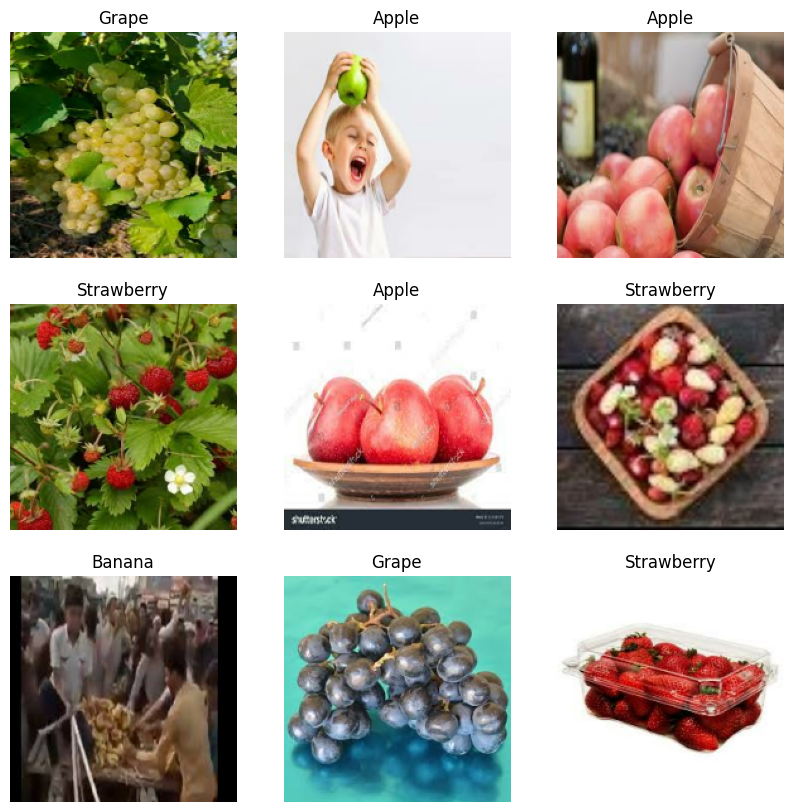

In [8]:
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):  # Pegar um lote de imagens
    
    for i in range(9):  # Mostrar as primeiras 9 imagens
        
        ax = plt.subplot(3, 3, i + 1) # exibição das imagens 3X3
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(nomes_classes[labels[i]]) # para mostrar o nome da classe
        
        plt.axis("off")
        
plt.show()

### Dados de treinamento e de validação 

In [9]:
# Definindo image_size e batch_size
image_size = (180, 180)
batch_size = 32

# Caminhos para os dados de treinamento e validação
treinamento_data = "../data/train"
validaca_data = "../data/valid"
test_data = "../data/test"

# Carregando os datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validaca_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 9796 files belonging to 6 classes.
Found 226 files belonging to 6 classes.


### Modelo RESNET 

In [12]:
# Definir a função get_model
def get_model(num_classes):
    base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes)(x)
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

# Criar e compilar o modelo
model = get_model(num_classes)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy']
)


In [13]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data = val_data,
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.6867 - loss: 0.9395 - val_accuracy: 0.8274 - val_loss: 0.4599
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.8559 - loss: 0.4018 - val_accuracy: 0.8761 - val_loss: 0.3563
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.8888 - loss: 0.3132 - val_accuracy: 0.8805 - val_loss: 0.3498
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.9223 - loss: 0.2220 - val_accuracy: 0.8628 - val_loss: 0.3542
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.9428 - loss: 0.1641 - val_accuracy: 0.8673 - val_loss: 0.3888
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9682 - loss: 0.1037 - val_accuracy: 0.8673 - val_loss: 0.3800
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.9722 - loss: 0.0866 - val_accuracy: 0.8850 - val_loss: 0.4662
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 944s 3s/step - accuracy: 0.9819 - loss: 0.0612 - val_accu

### Salvar o modelo

In [16]:
with open('../models/history1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [17]:
model.save('../models/modelo.h5')

In [20]:
from tensorflow.keras.models import load_model

# Carregar o modelo salvo
loaded_model = load_model('../models/modelo.keras')

# Verificar se o modelo foi carregado corretamente
print(loaded_model.summary())

ValueError: File not found: filepath=../models/modelo.keras. Please ensure the file is an accessible `.keras` zip file.

### Histórico do modelo

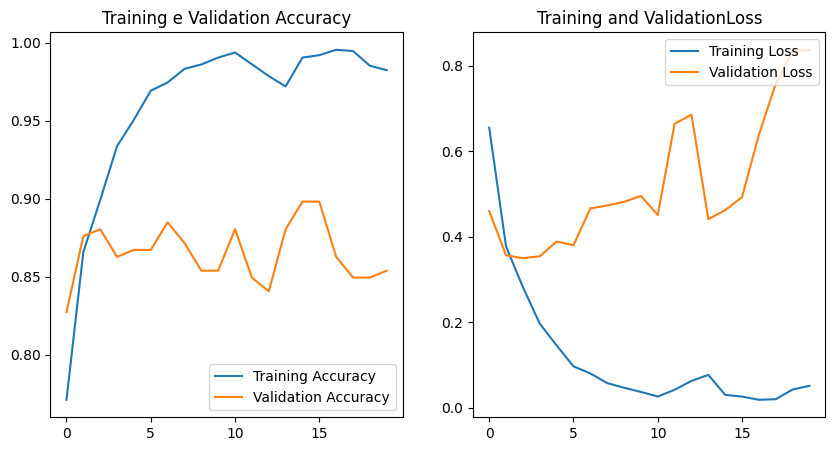

In [24]:
# mostrar o historico de treinamento

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training e Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and ValidationLoss')

plt.show()

### Validação do modelo 

In [23]:
# avaliar o modelo

test_loss, test_acc = model.evaluate(dataset, verbose=2)

print('\nTest accuracy:', test_acc)

print('\nTest loss:', test_loss)

307/307 - 459s - 1s/step - accuracy: 0.9836 - loss: 0.0435

Test accuracy: 0.9835647344589233

Test loss: 0.043481726199388504


Ajustar hiperparâmetros e arquitetura do modelo.
- aumentar a quantidade de parÂmetros para diminuir o overfitting

Aumentar o conjunto de dados para melhorar a precisão.

Utilizar técnicas de aumento de dados para melhorar a robustez do modelo.